In [1]:
import os, sys
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
sys.path.append('../readmaroc')
import seaborn as sns
from maroc_data_new_tboard import MarocData
from functools import partial
from scipy.stats import norm
from operator import add
from functools import reduce 
import operator
import json
input_dat = '../data/Run000137492.dat'
marocdata = MarocData(input_dat)

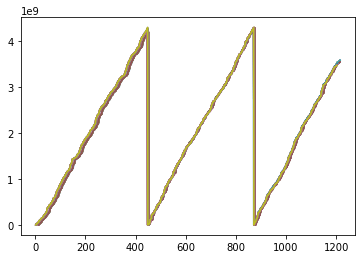

In [2]:
for board in marocdata.active_boards:
    plt.plot(marocdata.get_board(board).timestamps.keys(), marocdata.get_board(board).timestamps.values())
plt.show()

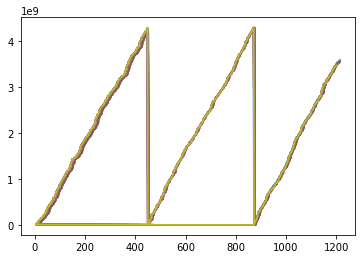

In [3]:
for board in marocdata.active_boards:
    plt.plot(marocdata.get_board(board).clean_timestamps.values(), 
             marocdata.get_board(board).clean_timestamps.keys())
plt.show()

In [5]:
marocdata.fix_p1(debug=False)

In [41]:
marocdata.check_clean_ts()

Timestamps of board 1 have been fixed


In [16]:
def take_consecutive(index_list):
    if len(index_list)<3:
        return None
    else:
        consecutive = []
        index_list = np.sort(index_list)
        for el, elp1 in zip(index_list, index_list[1:]):
            if elp1==el+1:
                consecutive.append(el)
                consecutive.append(elp1)
        if len(consecutive)==0:
            return None
        else:
            return np.unique(consecutive)

In [12]:
def over_threshold_per_board(marocdata, pedestals, noise):
    ts_over_threshold_per_board = {}
    for bid in marocdata.active_boards:
        timestamps = []
        board = marocdata.get_board(bid)
        for eid, signal in board.signals.items():
            if np.any((signal - pedestals[bid]) > noise[bid]):
                over = np.sort(np.where((signal - pedestals[bid]) > noise[bid])[0])
                consecutives = take_consecutive(over)
                if consecutives is None:
                    pass
                else:
                    if len(consecutives) <= 40:
                        event = board.get_event(eid)
                        # print(bid, eid, consecutives)
                        timestamps.append(event.TS_norm)
        ts_over_threshold_per_board[bid] = timestamps
    return ts_over_threshold_per_board

In [13]:
y_offset = [12000, 10000, 8000, 4000, 2000]
marocs = [(i, j) for i, j in zip(np.arange(0, 384, 64), np.arange(0, 384, 64)[1:])]

In [14]:

def board_plot(ax, ts, marocdata, board_id, board_idx, triplet_idx, c="blue"):
    if board_id in marocdata.active_boards:
        board = marocdata.get_board(board_id)
        if ts in board.clean_timestamps.keys():
            evt = board.clean_timestamps[ts]
            if evt in board:
                signal = board.signals[evt]
                if np.max(signal) > 2000:
                    signal = signal * 0.45
                pedestal = pedestals_tot[board_id]
                noise = noise_tot[board_id] 
                if np.any(signal - pedestal > noise):
                    over = np.where(signal - pedestal > noise)[0]
                    seed = np.max((signal - pedestal)[over])
                    over_x = np.where(signal - pedestal == seed)[0][0]
                    ax.scatter(
                                         over_x+ (board_idx * 320),
                                         seed + y_offset[triplet_idx],
                                         color='k', marker='s',
                                         s=400,facecolors='none', alpha=.7
                                     )
                ax.plot(
                    np.arange(0 + (board_idx * 320), 320 + 320 * board_idx),
                    (signal - pedestal) + y_offset[triplet_idx],
                    color=c,
                    linewidth=1,
                )
                #                 ax.plot(
                #                     np.arange(0 + (board_idx * 320), 320 + 320 * board_idx),
                #                     (noise) + y_offset[triplet_idx],
                #                     color='green',
                #                     linewidth=1,
                #                 )
                ax.text(
                    (320 + 320 * board_idx - 0 + (board_idx * 320)) / 2 - 150,
                    y_offset[triplet_idx] - 300,
                    "board: {}, evt:{}".format(board_id, evt),
                    size="small",
                )
                ax.axvline(
                    320 * (board_idx + 1),
                    linestyle="--",
                    linewidth=0.75,
                    color="grey",
                    alpha=0.5,
                )
    return ax


def plot_event_ts_new(ts, marocdata):
    print(ts)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10), sharey=True, sharex=True)
    evt = None
    for i, (triplet_y, triplet_x) in enumerate(
        zip(np.arange(1, 16).reshape(5, 3), np.arange(16, 31).reshape(5, 3))
    ):
        for j, (board_y, board_x) in enumerate(zip(triplet_y, triplet_x)):
            if board_y in marocdata.active_boards:
                yboard = marocdata.get_board(board_y)
                ax1 = board_plot(ax1, ts, marocdata, board_y, j, i)
            if board_x in marocdata.active_boards:
                xboard = marocdata.get_board(board_x)
                ax2 = board_plot(ax2, ts, marocdata, board_x, j, i, c="red")
    #    if (evt is None):
    #        return None # skip
    ax1.set_title("y layers", size="x-large")
    ax2.set_title("x layers", size="x-large")
    plt.yticks(
        y_offset,
        ["layer 0", "layer 1", "layer 2", "layer 3", "layer 4"],
        size="x-large",
    )
    plt.xticks([0, 320, 640, 960])
    fig.text(0.5, 0.05, "strips", size="large")
    fig.text(0.5, 0.95, "TS {}".format(ts), size="large")
    plt.ylim(1000, 13000)
    plt.xlim(-10, 970)
    return fig, ax1, ax2



In [67]:
marocdata.check_clean_ts()

Timestamps of board 1 have been fixed


In [10]:
pedestals_tot = marocdata.pedestals_tot
noise_tot = marocdata.noise_tot(4)

In [17]:
ts_over_threshold = over_threshold_per_board(marocdata, pedestals_tot, noise_tot)

all_ts = reduce(add, ts_over_threshold.values())

In [18]:
ts_over_threshold

{1: [2690723915],
 2: [1498477343, 3242694274],
 3: [],
 4: [218433683,
  2468318419,
  3504449564,
  3881185367,
  1466953012,
  2401621640,
  2763548747],
 5: [1532182264,
  2823885232,
  713064588,
  3216309750,
  3616791488,
  3825886386,
  1672787840,
  2078123995,
  2502684387],
 6: [983535827, 1855514825, 3333469852, 519904783, 613207182],
 7: [423152684,
  584848772,
  1458444293,
  3280827483,
  925436719,
  1773566610,
  3015614535,
  3785369756,
  1292527551,
  1979575942,
  2401621640],
 8: [3480995392,
  1555534304,
  2445945054,
  2467530233,
  569846197,
  2025422909,
  2258705994,
  2359991769],
 9: [1458444293, 3179245078],
 10: [612554681, 2064448517, 880107239, 3400193766],
 11: [1148561243, 3153817401, 1059029277],
 12: [94371096,
  1202015413,
  2985420412,
  4625629,
  108993145,
  2300625016,
  2338318585,
  2640151760],
 13: [1202015413,
  1744647761,
  1907377338,
  2174047651,
  2506370347,
  3696230032,
  4625629,
  311033622,
  595278511,
  2190563666,
  244

In [19]:
xx, yy = zip(*Counter(all_ts).items())

In [8]:
marocdata.check_clean_ts()

Timestamps of board 1 have been fixed


In [20]:
marocdata.get_board(1).clean_timestamps

{7835407: 14,
 8818333: 15,
 16653741: 16,
 30927497: 17,
 31207319: 18,
 35782484: 19,
 36765517: 20,
 41695041: 21,
 52701298: 22,
 57174582: 23,
 57573521: 24,
 61756159: 25,
 67040352: 26,
 94752378: 27,
 95500281: 28,
 103189429: 29,
 106595013: 30,
 108232466: 31,
 115597027: 32,
 122859366: 33,
 126541729: 34,
 139269943: 35,
 146678289: 36,
 148039963: 37,
 152159274: 38,
 155259848: 39,
 159885092: 40,
 166142234: 41,
 168585372: 42,
 171789721: 43,
 178239533: 44,
 191666028: 45,
 206697354: 46,
 214785891: 47,
 222692444: 48,
 227252016: 49,
 231502953: 50,
 235890188: 51,
 245174509: 52,
 256384913: 53,
 259224612: 54,
 269134795: 55,
 277222297: 56,
 278664834: 57,
 292792223: 58,
 315695180: 59,
 366794737: 60,
 369453444: 61,
 370525473: 62,
 378267187: 63,
 390407125: 64,
 402882951: 65,
 405809267: 66,
 419083638: 67,
 431455779: 68,
 431751444: 69,
 431971017: 70,
 447435286: 71,
 448793355: 72,
 455532107: 73,
 456704638: 74,
 463888275: 75,
 489674585: 76,
 49020618

In [28]:
marocdata.get_board(2).clean_timestamps

{0: 874,
 7835407: 15,
 22109164: 16,
 22388986: 17,
 26964151: 18,
 27947184: 19,
 32876707: 20,
 43882964: 21,
 48356249: 22,
 48755187: 23,
 52937825: 24,
 58222018: 25,
 85934045: 26,
 86681948: 27,
 94371096: 28,
 97776680: 29,
 99414133: 30,
 106778694: 31,
 114041033: 32,
 117723396: 33,
 130451609: 34,
 137859955: 35,
 139221630: 36,
 143340941: 37,
 146441515: 38,
 151066759: 39,
 157323901: 40,
 159767039: 41,
 162971387: 42,
 169421200: 43,
 182847695: 44,
 197879021: 45,
 205967557: 46,
 213874110: 47,
 218433683: 48,
 222684620: 49,
 227071854: 50,
 236356175: 51,
 247566580: 52,
 250406279: 53,
 260316462: 54,
 268403964: 55,
 269846501: 56,
 283973890: 57,
 306876847: 58,
 357976404: 59,
 360635110: 60,
 361707139: 61,
 369448854: 62,
 381588792: 63,
 394064617: 64,
 396990934: 65,
 410265305: 66,
 422637446: 67,
 422933111: 68,
 423152684: 69,
 438616952: 70,
 439975022: 71,
 446713773: 72,
 447886304: 73,
 455069942: 74,
 480856252: 75,
 481387856: 76,
 481661226: 77,


In [22]:
marocdata.fix_p1(debug=False)

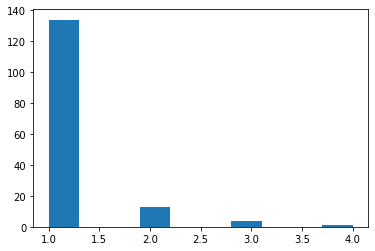

In [23]:
plt.hist(yy, bins=10)
plt.show()

In [24]:
ts_to_plot = [ts for ts, occ in Counter(all_ts).items() if occ >= 3]

In [25]:
ts_to_plot

[2468318419, 1202015413, 3280572517, 4132466827, 2783132320]

2468318419


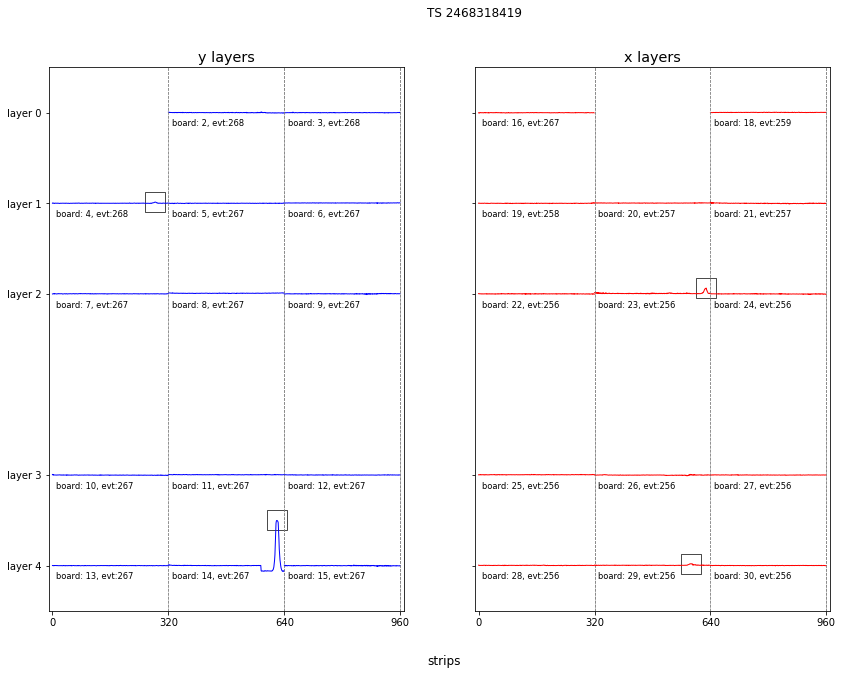

1202015413


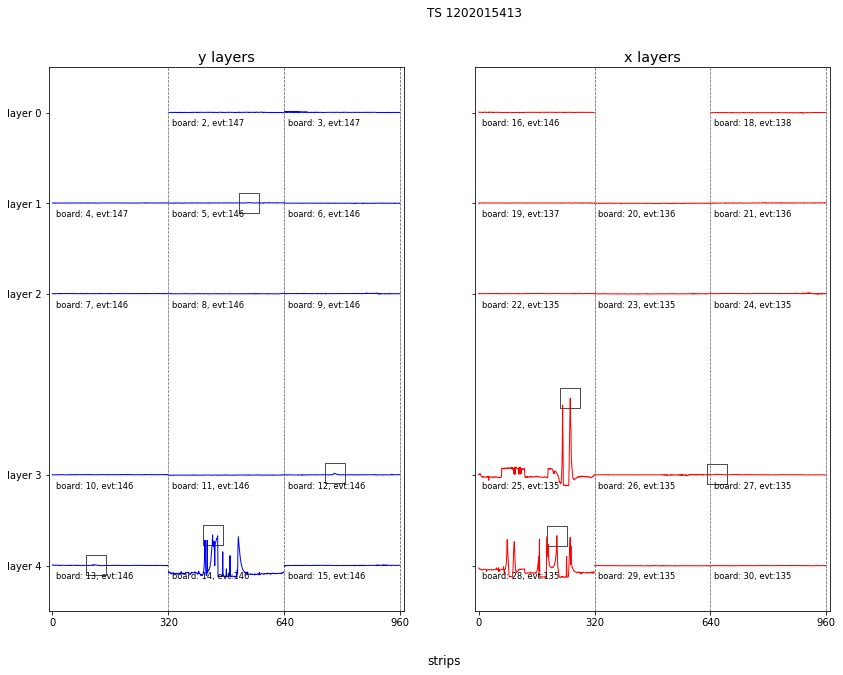

3280572517


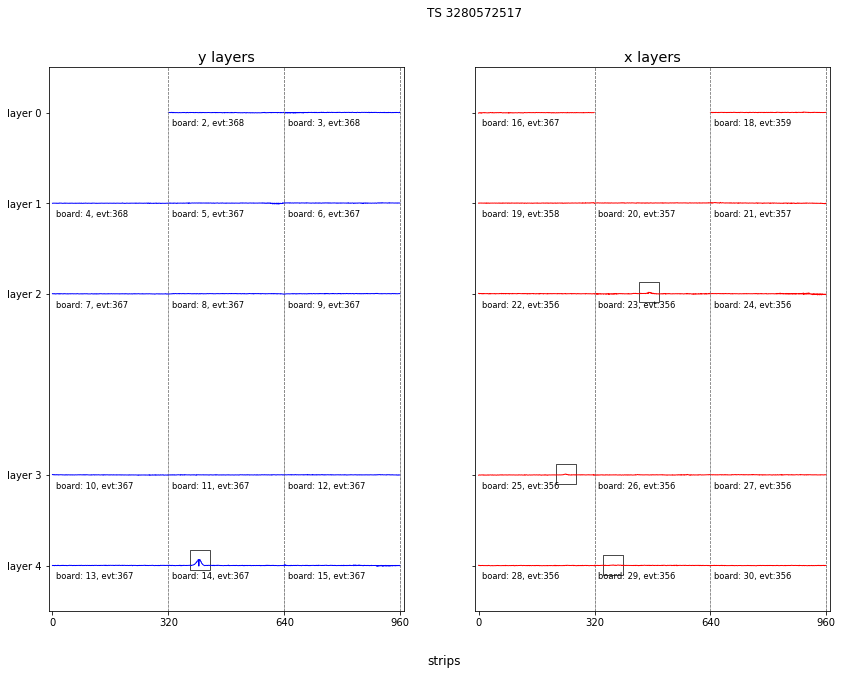

4132466827


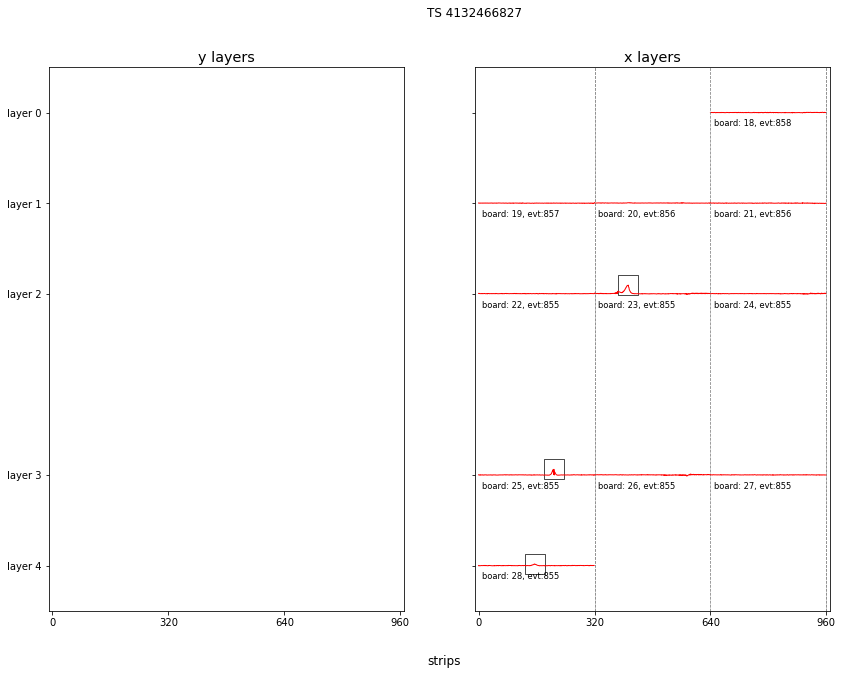

2783132320


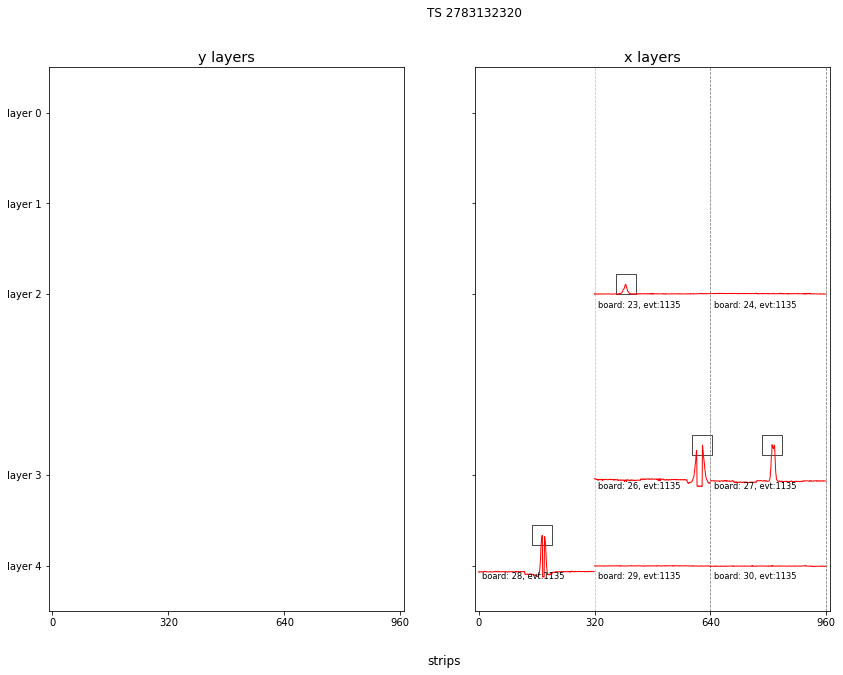

In [26]:
for ts in ts_to_plot:
    fig, ax1, ax2 = plot_event_ts_new(ts, marocdata)
    plt.show()